<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/S11_disruption_management/Module1A_Disruption_Risk_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Session 11: Distruption risk analytics

---
As usual, we start our prescriptive modeling by installing the (i) Pyomo package and (ii) the linear programming solver GLPK (GNU Linear Programming Kit). Please feel free to revisit [Session 9](https://github.com/acedesci/scanalytics/blob/master/S8_9_retail_analytics/S9_Module2A_Retail_Price_Optimization.ipynb) for further information. 

In [ ]:
# Install Pyomo and GLPK
!pip install -q pyomo
!apt-get install -y -qq glpk-utils #if GLPK is used

     |████████████████████████████████| 2.5MB 2.8MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 266kB 22.1MB/s 
     |████████████████████████████████| 163kB 22.5MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 133872 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-

# Blocks 1&2: Data inputs and parameters

We have two different datasets. The latter has more complex configurations, but their structures are similar.

*   In problem 1, the instance consists of 3 suppliers, 2 products (vehicles) and 4 scenarios. There is only one supply chain configuration;
*   In problem 2, the instance consists of 5 suppliers, 8 products (vehicles) and 21 scenarios. There are three supply chain configurations (A, B and C) and the analysis for each configuration must be done separately (in different runs).

We would recommend that you review problem 1 to see the structure of the model prior to trying the problem 2.

### Details of data inputs & parameters ###
The DataFrame **inputScenarios** contains the values of active link $\alpha_{ij}^n$ from supply node $i$ for product/vehicle $j$ each scenario $n$. $\alpha_{ij}^n = 1$ indicates that that link is active in this scenario whereas $\alpha_{ij}^n=0$ indicates that the link is inactive (disrupted/not used) in that scenario.

Meanwhile, the DataFrame **inputParameters** contains a set of parameters as follows:
 () contains the capacity of each supplier (in **supplierList**), demand for 

*   Column *Type* indicates if the parameter is for the supply node (Supplier) or product node (Product)
*   Column *Parameter* indicates what parameter is given in that row. The parameters include
> *   Capacity of supply node $i$: $c_i$
> *   Demand of product node $j$: $d_j$
> *   Initial inventory of product $j$: $s_j$
> *   Unit profit (profit margin) of product $j$: $f_j$
> *   Time-to-recover (TTR) of each scenario $n$: $t^n$

*   Column *Index* indicates the index associated with that parameter
*   Column *Value* indicates the value of that parameter

In [ ]:
import pandas
from pyomo.environ import *

# Problem 1 (small scale, one configuration)
urlParameters = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S11_disruption_management/inputParameters_Prob1.csv'
urlScenario  = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S11_disruption_management/inputScenarios_Prob1.csv'

# Problem 2 (large scale, 3 possible SC configurations - A, B and C)
# urlParameters = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S11_disruption_management/inputParameters_Prob2.csv'

# Here are the scenarios under each configuration. The analysis could be done for one SC configuration at a time so only choose one url among them.
# urlScenario  = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S11_disruption_management/inputScenarios_Prob2_Config_A.csv'
# urlScenario  = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S11_disruption_management/inputScenarios_Prob2_Config_B.csv'
# urlScenario  = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S11_disruption_management/inputScenarios_Prob2_Config_C.csv'

# read CSV files
inputScenarios = pandas.read_csv(urlScenario)
inputParameters = pandas.read_csv(urlParameters)

# Just in case you want to see the loaded DataFrames, you can display or print them 
# (display gives a more beautiful output for DataFrame)
from IPython.display import display
display(inputScenarios)
display(inputParameters)

,Node,Product,Scenario_0,Scenario_1,Scenario_2,Scenario_3
0,S1,P1,1,0,1,1
1,S1,P2,1,0,1,1
2,S2,P1,1,1,0,1
3,S2,P2,1,1,0,1
4,S3,P1,1,1,1,0
5,S3,P2,1,1,1,0


,Type,Parameter,Index,Value
0,Supplier,Capacity,S1,30
1,Supplier,Capacity,S2,45
2,Supplier,Capacity,S3,60
3,Product,Demand,P1,75
4,Product,Demand,P2,50
5,Product,Inventory,P1,20
6,Product,Inventory,P2,25
7,Product,Loss,P1,5000
8,Product,Loss,P2,6500
9,Disruption,TTR,Scenario_0,2



We then create the inputs used in the Pyomo model from the DataFrames above.


**Lists**: 
*   **productList** contains the list of products (vehicles), or set $\mathcal{V}$
*   **supplierList** contains the list of supply nodes (plants), or set $\mathcal{A}$
*   **scenarioList** contains the list of scenarios

**Dictionaries of data**:
*  **supplierCapacityDict[i]** contains the values of $c_i$;
*  **productDemandDict[j]** contains the values of $d_j$;
*  **productInvDict[j]** contains the values of $s_j$;
*  **productLossDict[j]** contains the values of $f_j$;
*  **scenarioTTRDict[n]** contains the values of $t^n$;
* **scenarioActiveNodeDict[n][(i,j)]** contains the values of $\alpha^n_{ij}$ whether the link $(i,j)$ is active in scenario $n$ for not.




In [ ]:
productList = inputParameters.loc[inputParameters['Type']=='Product']['Index'].unique()
supplierList = inputParameters.loc[inputParameters['Type']=='Supplier']['Index'].unique()
scenarioList = inputParameters.loc[inputParameters['Type']=='Disruption']['Index'].unique()

supplierCapacityDict = {}
for i in supplierList:
  cap = inputParameters.loc[(inputParameters['Parameter']=='Capacity') & (inputParameters['Index']==i)]['Value'].values[0]
  supplierCapacityDict[i] = cap

print('Print SupplierCapacityDict')
for key in supplierCapacityDict:
    print(key, ' : ', supplierCapacityDict[key])
#print('\n')

productDemandDict = {}
productInvDict = {}
productLossDict = {}

for j in productList:
  dem = inputParameters.loc[(inputParameters['Parameter']=='Demand') & (inputParameters['Index']==j)]['Value'].values[0]
  inv = inputParameters.loc[(inputParameters['Parameter']=='Inventory') & (inputParameters['Index']==j)]['Value'].values[0]
  loss = inputParameters.loc[(inputParameters['Parameter']=='Loss') & (inputParameters['Index']==j)]['Value'].values[0]
  productDemandDict[j] = dem
  productInvDict[j] = inv
  productLossDict[j] = loss

print('Print productDemandDict')
for key in productDemandDict:
    print(key, ' : ', productDemandDict[key])
#print('\n')

print('Print productInvDict')
for key in productInvDict:
    print(key, ' : ', productInvDict[key])
#print('\n')

print('Print productLossDict')
for key in productLossDict:
    print(key, ' : ', productLossDict[key])
#print('\n')

scenarioTTRDict = {}
scenarioActiveNodeDict = {}
for n in scenarioList:
  ttr = inputParameters.loc[(inputParameters['Parameter']=='TTR') & (inputParameters['Index']==n)]['Value'].values[0]
  scenarioTTRDict[n] = ttr
  scenarioActiveNodeDict[n] = {}
  avgNActiveLinks = sum(inputScenarios[n].values)/len(supplierList)
  print(str(n)+": avg N. active links = {0:.2f}".format(round(avgNActiveLinks,2)))
  
  for ind in range(len(inputScenarios.index)):
    supp = inputScenarios.iloc[ind]['Node']
    prod = inputScenarios.iloc[ind]['Product']
    scenarioActiveNodeDict[n][(supp,prod)] = inputScenarios[n].values[ind]

Print SupplierCapacityDict
S1  :  30
S2  :  45
S3  :  60
Print productDemandDict
P1  :  75
P2  :  50
Print productInvDict
P1  :  20
P2  :  25
Print productLossDict
P1  :  5000
P2  :  6500
Scenario_0: avg N. active links = 2.00
Scenario_1: avg N. active links = 1.33
Scenario_2: avg N. active links = 1.33
Scenario_3: avg N. active links = 1.33


# Blocks 3 & 4: Optimization model & results

Since the risk exposure analytics framework requires solving one linear programming (LP) for each scenario at a time, we make use of the *for* loop to perform the procedure which create an LP which is loaded with the parameters for each scenario $n$ and solve the model iteratively to obtain the optimal solution corresponding to that scenario.  There are two optimizatiom models, i.e., TTR and TTS models.

---



### Block 3A: **TTR Model:**

The first model is the best-response model based on the TTR. The components of the models are as follows. Note that these variables are created for each scenario but the scenario index $n$ is dropped:

(i) **Decision variables:** consists of the following variables:
*   model.**l**$[j]$ (or $l_{j}$): the number of unit loss of product *j* at supplier *i*;
*   model.**y**$[i, j]$ (or $y_{ij}$) the amount of product *j* produced at supplier *i*;

(ii) **Objective function:** In the TTR model, we want to minimize the total profit loss due to disruption in each scenario, i.e.,

$$\min_{y,l} \sum_{j\in \mathcal{V}} f_j \cdot l_j$$

(iii) **Constraints:**

**Constraint set 1:**  demand loss for product $j$ **

This set of constraints helps determine the lower bound on the demand lost ($l_j$) during the disruption time ($t^{n}$) given the current inventory level ($s_j$) and the production amount for product $j$ from supplier $i$ ($y_{ij}$) from the active link $\alpha^{n}_{ij}=1$.
$$\sum_{i\in\mathcal{A}} \left( \alpha^{n}_{ij} \cdot y_{ij} \right) + l_j \geq d_j \cdot t^{n} - s_j,\quad \forall j\in \mathcal{V} $$

**Constraint set 2:**  capacity at each supplier $i$

This set of constraints ensures that the cumulative production output of supplier $i$ is within the capacity of that supplier if it is still active $\left(\alpha^{n}_{ij}=1\right)$. Note that we need to check if at least one link $\alpha^{n}_{ij}$ for supplier $i$ is active for that scenario, otherwise Pyomo will return an error. In the case when there is no active link, we will omit that supplier in the model (since that supplier will not be used anyway). This is done in the codes when we use the boolean *noSupply*. 

$$\sum_{j\in\mathcal{V}} \alpha^{n}_{ij} \cdot y_{ij}  \leq c_i \cdot t^{(n)},\quad \forall i\in \mathcal{A} $$

### Block 4: Solution and results

To aggregate the results from each scenario, we calculate and store the results in the **scenarioResults** DataFrame which stores the following results based on the optimal solution $\left( \mathbf{l}^{n,*}, \mathbf{y}^{n,*} \right)$ for each scenario $n$ : 'disruptionCost' $\left( \sum_j f_j \cdot l_j^{n,*} \right)$, 'riskExposureIndex' $\left( \frac{C^n}{C^{\max}} \right)$, 'lostUnits' $\left( \sum_j l_j^{n,*} \right)$, 'totalProduction' $\left( \sum_i \sum_j \alpha^{n}_{ij} \cdot y_{ij}^{n,*} \right)$, 'disruptedLinks' $\left( \sum_i\sum_j \left(1-\alpha^{n}_{ij}\right) \right)$, and 'activeLinks' $\left( \sum_i\sum_j \alpha^{n}_{ij}\right)$.


Finally, we display the descriptive statistics of the results over all disruption scenarios. Here we make use of function *discribe()* in pandas [(Link)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) and *hist()* in matplotlib [(Link)](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.hist.html).





,disruptionCost,riskExposureIndex,lostUnits,totalProduction,disruptedLinks,activeLinks
Scenario_0,0.0,0.0,0.0,205.0,0,4
Scenario_1,0.0,0.0,0.0,205.0,2,3
Scenario_2,"125,000.0",0.5,25.0,180.0,2,3
Scenario_3,"275,000.0",1.0,55.0,150.0,2,3


,disruptionCost,riskExposureIndex,lostUnits,totalProduction,disruptedLinks,activeLinks
count,4.0,4.0,4.0,4.0,4.0,4.0
mean,"100,000.0",0.4,20.0,185.0,1.5,3.2
std,"130,703.2",0.5,26.1,26.1,1.0,0.5
min,0.0,0.0,0.0,150.0,0.0,3.0
10%,0.0,0.0,0.0,159.0,0.6,3.0
50%,"62,500.0",0.2,12.5,192.5,2.0,3.0
90%,"230,000.0",0.8,46.0,205.0,2.0,3.7
max,"275,000.0",1.0,55.0,205.0,2.0,4.0


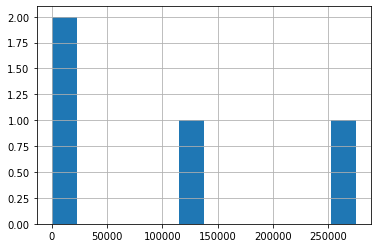

,disruptionCost,riskExposureIndex,lostUnits,totalProduction,disruptedLinks,activeLinks
Scenario_0,0.0,0.0,0.0,205.0,0,4
Scenario_1,0.0,0.0,0.0,205.0,2,3
Scenario_2,"125,000.0",0.5,25.0,180.0,2,3
Scenario_3,"275,000.0",1.0,55.0,150.0,2,3


In [ ]:
# TTR Model 

disruptionCost = {}
disruptionResponse = {}
disruptionDemandLoss = {}


resultcolumns = ['disruptionCost', 'riskExposureIndex', 'lostUnits', 'totalProduction', 'disruptedLinks','activeLinks']
scenarioResults = pandas.DataFrame(columns = resultcolumns, index = scenarioList)

for n in scenarioList:
  # print("Analyzing:"+str(n))
  model = ConcreteModel()
  
  # Variables
  model.l = Var(productList, within = NonNegativeReals)
  model.y = Var(supplierList, productList, within = NonNegativeReals)

  model.demandLoss = ConstraintList()
  model.supplierCapacity = ConstraintList()

  # Objective function
  obj_expr = sum(productLossDict[j]*model.l[j] for j in productList)
  # print(obj_expr)
  model.OBJ = Objective(expr = obj_expr, sense = minimize)

  # Constraints 1 calculate demand loss for each product
  for j in productList:
    const_expr = sum(scenarioActiveNodeDict[n][(i,j)]*model.y[(i,j)] for i in supplierList) + \
                  model.l[j] >= productDemandDict[j]*scenarioTTRDict[n] - productInvDict[j] 
    # print(const_expr)
    model.demandLoss.add(expr = const_expr)

  # Constraints 2 capacity at each supplier i
  for i in supplierList:
    # check if there is any left hand side (i.e., if there is at least one available active link), otherwise pyomo will return an error
    noSupply = True
    for j in productList:
      if scenarioActiveNodeDict[n][(i,j)] > 0: 
        noSupply = False
        break

    # we generate the constraint only if noSupply = False
    if not noSupply:
      const_expr = sum(scenarioActiveNodeDict[n][(i,j)]*model.y[(i,j)] for j in productList) <= supplierCapacityDict[i]*scenarioTTRDict[n]
      #print(const_expr)
      model.supplierCapacity.add(expr = const_expr)

  # Solve the model
  opt = SolverFactory('glpk')
  opt.solve(model) 

  # Save the result for each scenario

  disruptionCost[n] = model.OBJ()
  scenarioResults.loc[n, 'disruptionCost'] = disruptionCost[n]
  
  disruptionResponse[n] = {}
  nActiveLinks = 0
  for ind in range(len(inputScenarios.index)):
      i = inputScenarios.iloc[ind]['Node']
      j = inputScenarios.iloc[ind]['Product']

      if model.y[(i,j)].value is not None:
        disruptionResponse[n][(i,j)] = model.y[(i,j)].value
        if model.y[(i,j)].value > 0.1:
          nActiveLinks += 1
      else: 
        disruptionResponse[n][(i,j)] = 0

  scenarioResults.loc[n, 'totalProduction'] = sum(disruptionResponse[n].values())
  scenarioResults.loc[n, 'activeLinks'] = nActiveLinks
  scenarioResults.loc[n, 'disruptedLinks'] = len(inputScenarios.index) - sum(scenarioActiveNodeDict[n].values())

  disruptionDemandLoss[n] = {}
  for j in productList:
    disruptionDemandLoss[n][j] = model.l[j].value

  scenarioResults.loc[n, 'lostUnits'] = sum(disruptionDemandLoss[n].values())

if scenarioResults['disruptionCost'].max() > 0.001:
  scenarioResults['riskExposureIndex'] = scenarioResults['disruptionCost']/scenarioResults['disruptionCost'].max()
else: scenarioResults['riskExposureIndex'] = 0.0

# Intepret and show the results
from IPython.display import display

# Here we make use of the function describe() for DataFrame
pandas.options.display.float_format = '{:,.1f}'.format
display(scenarioResults)
display(scenarioResults.astype(float).describe(percentiles = [.10, .90]))
print('\n')

%matplotlib inline
import matplotlib.pyplot as plt
# Here we make use of the function hist() to plot the histogram
scenarioResults['disruptionCost'].astype(int).hist(bins=12)
plt.show()

display(scenarioResults)

### Block 3B: **TTS Model:**

The second model is the time-to-survive (TTS) model to determine how long the disrupted supply chain can last until the demand is lost. The components of the models are as follows. 

(i) **Decision variables:** consist of:
*   model.**t**$[n]$ (or $t^{n}$): time-to-survive (TTS) for scenario $n$
*   model.**y**$[i, j]$ (or $y_{ij}$) the amount of product *j* produced at supplier *i*;


(ii) **Objective function:** In the TTS model, we want to maximize the TTS in each scenario, i.e.,

$$\max_{y,t} t^n$$

(iii) **Constraints:**

**Constraint set 1:**  demand of product $j$ must be satisfied without loss**

This set of constraints helps determine how long the demand can be fully satisfied without loss ($t^{n}$) given the current inventory level ($s_j$) and the production amount for product $j$ from supplier $i$ ($y_{ij}$) if the  link is active $\alpha^{n}_{ij}=1$.
$$\sum_{i\in\mathcal{A}} \alpha^{n}_{ij} \cdot y_{ij} \geq d_j \cdot t^{n} - s_j,\quad \forall j\in \mathcal{V} $$

**Constraint set 2:**  capacity at each supplier $i$

This set of constraints ensures that the cumulative production output of supplier $i$ is within the capacity of that supplier if it is still active $\left(\alpha^{n}_{ij}=1\right)$. Note that we need to check if at least one link $\alpha^{n}_{ij}$ for supplier $i$ is active for that scenario, otherwise Pyomo will return an error. In the case when there is no active link, we will omit that supplier in the model (since that supplier will not be used anyway). This is done in the codes when we use the boolean *noSupply*. 

$$\sum_{j\in\mathcal{V}} \alpha^{n}_{ij} \cdot y_{ij}   \leq c_i \cdot t^{(n)},\quad \forall i\in \mathcal{A} $$

### Block 4: Solution and results

To aggregate the results from each scenario, we calculate and store the results in the **scenarioResults** DataFrame which stores the following results based on the optimal solution $\left( t^{n,*}, \mathbf{y}^{n,*} \right)$ for each scenario $n$ : 'TTS' $(t^n)$, 'totalProduction' $\left( \sum_i \sum_j \alpha^{n}_{ij} \cdot y_{ij}^{n,*} \right)$, 'disruptedLinks' $\left( \sum_i\sum_j \left(1-\alpha^{n}_{ij}\right) \right)$, and 'activeLinks' $\left( \sum_i\sum_j \alpha^{n}_{ij}\right)$.


Finally, we display the descriptive statistics of the results over all disruption scenarios. Here we make use of function *discribe()* in pandas [(Link)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) and *hist()* in matplotlib [(Link)](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.hist.html).


,TTS,TTR,totalProduction,disruptedLinks,activeLinks
count,4.0,4.0,4.0,4.0,4.0
mean,25.9,2.0,"3,187.4",1.5,3.2
std,48.8,0.0,"6,095.5",1.0,0.5
min,0.9,2.0,67.5,0.0,3.0
10%,1.0,2.0,82.0,0.6,3.0
50%,1.8,2.0,176.0,2.0,3.0
90%,70.0,2.0,"8,701.9",2.0,3.7
max,99.0,2.0,"12,330.0",2.0,4.0


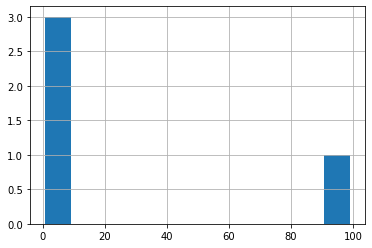

,TTS,TTR,totalProduction,disruptedLinks,activeLinks
Scenario_0,99.0,2,"12,330.0",0,4
Scenario_1,2.2,2,236.2,2,3
Scenario_2,1.3,2,115.7,2,3
Scenario_3,0.9,2,67.5,2,3


In [ ]:
# TTS Model 

timeToSurvive = {}
disruptionResponse = {}
disruptionDemandLoss = {}

resultcolumns = ['TTS', 'TTR', 'totalProduction', 'disruptedLinks','activeLinks']
scenarioResults = pandas.DataFrame(columns = resultcolumns, index = scenarioList)

for n in scenarioList:
  # print("Analyzing:"+str(n))
  model = ConcreteModel()
  
  # Variables
  # There is only one variable t so we give a list of one value. 
  # If the SC is robust for that scenario, the variable t will be equal to infinity 
  # so we limit the max to a sufficiently large number (99 periods in this case)
  model.t = Var([0], within = NonNegativeReals, bounds=(0,99)) 
  model.y = Var(supplierList, productList, within = NonNegativeReals)

  model.demandSatisfaction = ConstraintList()
  model.supplierCapacity = ConstraintList()

  # Objective function
  obj_expr =model.t[0]
  # print(obj_expr)
  model.OBJ = Objective(expr = obj_expr, sense = maximize)

  # Constraints 1 demand must be fully satisfied
  for j in productList:
    const_expr = sum(scenarioActiveNodeDict[n][(i,j)]*model.y[(i,j)] for i in supplierList) \
                  >= productDemandDict[j]*model.t[0] - productInvDict[j]
    # print(const_expr)
    model.demandSatisfaction.add(expr = const_expr)

  # Constraints 2 capacity at each supplier i
  for i in supplierList:
    # check if there is any left hand side (i.e., if there is at least one available active link), otherwise pyomo will return an error
    noSupply = True
    for j in productList:
      if scenarioActiveNodeDict[n][(i,j)] > 0: 
        noSupply = False
        break

    # we generate the constraint only if noSupply = False
    if not noSupply:
      const_expr = sum(scenarioActiveNodeDict[n][(i,j)]*model.y[(i,j)] for j in productList) <= supplierCapacityDict[i]*model.t[0]
      #print(const_expr)
      model.supplierCapacity.add(expr = const_expr)

  # Solve the model
  opt = SolverFactory('glpk')
  opt.solve(model) 

  # Save the result for each scenario

  timeToSurvive[n] = model.OBJ()
  scenarioResults.loc[n, 'TTS'] = timeToSurvive[n]
  scenarioResults.loc[n, 'TTR'] = scenarioTTRDict[n]

  disruptionResponse[n] = {}
  nActiveLinks = 0
  for ind in range(len(inputScenarios.index)):
      i = inputScenarios.iloc[ind]['Node']
      j = inputScenarios.iloc[ind]['Product']

      if model.y[(i,j)].value is not None:
        disruptionResponse[n][(i,j)] = model.y[(i,j)].value
        if model.y[(i,j)].value > 0.1:
          nActiveLinks += 1
      else: 
        disruptionResponse[n][(i,j)] = 0

  scenarioResults.loc[n, 'totalProduction'] = sum(disruptionResponse[n].values())
  scenarioResults.loc[n, 'activeLinks'] = nActiveLinks
  scenarioResults.loc[n, 'disruptedLinks'] = len(inputScenarios.index) - sum(scenarioActiveNodeDict[n].values())

# Intepret and show the results
from IPython.display import display
# Here we make use of the function describe() for DataFrame
pandas.options.display.float_format = '{:,.1f}'.format
display(scenarioResults.astype(float).describe(percentiles = [.10, .90]))
print('\n')

%matplotlib inline
import matplotlib.pyplot as plt
# Here we make use of the function hist() to plot the histogram
scenarioResults['TTS'].hist(bins=12)
plt.show()

display(scenarioResults)